# Preparing final figures for paper

In [1]:
# Load Packages
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(data.table)
    library(RColorBrewer)
    library(scran)
    library(scater)
})

In [2]:
# I/O
here::i_am("processing/1_create_seurat_rna.R")
source(here::here("settings.R"))
source(here::here("utils.R"))

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/code



In [3]:
# Options

# Functions 
# minmax normalisation 
minmax = function(x){(x-min(x))/(max(x)-min(x))}
# Reversing vector order (for pseudotime)
reverse = function(x){-x + max(x) + min(x)}

In [4]:
# Load metadata (always needed)
meta = fread(file.path(io$basedir, 'results/rna/mapping/sample_metadata_after_mapping.txt.gz'))[pass_rnaQC==TRUE & doublet_call==FALSE]

## Main figure

In [5]:
umap.dt = fread(file.path(io$basedir, 'results/rna/dimensionality_reduction/sce/umap_features2500_pcs40_neigh30_dist0.3.txt.gz')) %>% 
    merge(meta, by='cell')

In [6]:
############
## Panel B
############


# Scrambeling input data.table so cells are not plotted in order of sample
p1 = ggplot(umap.dt[sample(1:nrow(umap.dt)),], aes(UMAP1, UMAP2, col = celltype.mapped_mnn)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=opts$celltype.colors) +
        theme_bw() + 
        theme(legend.position='none',
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank()
        )

p2 = ggplot(umap.dt[sample(1:nrow(umap.dt)),], aes(UMAP1, UMAP2, col = stage)) + 
        geom_point(size=0.2) + 
        scale_color_manual(values=opts$stage.colors) +
        theme_bw() + 
        theme(legend.position='none',
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank()
        )
p3 = ggplot(umap.dt[sample(1:nrow(umap.dt)),], aes(UMAP1, UMAP2, col = tdTom_corr)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values=opts$tdTom.color) +
        theme_bw() + 
        theme(legend.position='none',
          axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank()
        )

pdf(file.path(io$basedir, '/results/Main/UMAP_celltype.pdf'), width=7, height=5)
    print(p1)
dev.off()

pdf(file.path(io$basedir, '/results/Main/UMAP_stage.pdf'), width=7, height=5)
    print(p2)
dev.off()

pdf(file.path(io$basedir, '/results/Main/UMAP_tomato.pdf'), width=7, height=5)
    print(p3)
dev.off()

# Export figure legends as well!

png 
  2

png 
  2

png 
  2

In [7]:
celltype_legend = as_ggplot(get_legend(ggplot(umap.dt[sample(1:nrow(umap.dt)),], aes(UMAP1, UMAP2, col = celltype.mapped_mnn)) + 
        geom_point(size=5) + 
        scale_color_manual(values=opts$celltype.colors) +
        theme_bw() + 
        theme(legend.text = element_text(size=20),
              legend.title = element_blank())))

pdf(file.path(io$basedir, '/results/Main/celltype_legend.pdf'), width=25, height=5)
    print(celltype_legend)
dev.off()

png 
  2

In [8]:
############
## Panel C
############

# Load MILO results
milo = readRDS(file.path(io$basedir, 'results/rna/MiloR/E9.5_Milo_features2500_pcs40_tdTomcorrFalse.rds'))
milo_results = fread(file.path(io$basedir, 'results/rna/MiloR/E9.5_Milo_features2500_pcs40_tdTomcorrFalse_DAresults.csv'))

# Put the UMAP into the milo object
umap.mtx = umap.dt[,c(1,2,3)] %>% 
    .[match(colnames(milo), cell),] %>% 
    .[!is.na(cell)]  %>% 
     as.data.frame() %>% tibble::column_to_rownames('cell') %>% 
     as.matrix

summary(rownames(umap.mtx) == colnames(milo))

reducedDims(milo)$umap = umap.mtx

Loading required package: miloR

Loading required package: edgeR

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




   Mode    TRUE 
logical   21455 

In [9]:
# Tweak the graph plotting to also incluse the cells in the background
plotNhoodGraph_with_cells = function(x, layout = "UMAP", colour_by = NA, subset.nhoods = NULL, 
    size_range = c(0.5, 3), node_stroke = 0.3, ...) 
{
    if (!miloR:::.valid_graph(nhoodGraph(x))) {
        stop("Not a valid Milo object - neighbourhood graph is missing. Please run buildNhoodGraph() first.")
    }
    if (is.character(layout)) {
        if (!layout %in% names(reducedDims(x))) {
            stop(layout, "isn't in readucedDim(x) - choose a different layout")
        }
    }
    nh_graph <- nhoodGraph(x)
    if (!is.null(subset.nhoods)) {
        nh_graph <- igraph::induced_subgraph(nh_graph, vids = which(as.numeric(V(nh_graph)$name) %in% 
            unlist(nhoodIndex(x)[subset.nhoods])))
    }
    nh_graph <- igraph::permute(nh_graph, order(igraph::vertex_attr(nh_graph)$size, 
        decreasing = TRUE))
    if (is.character(layout)) {
        redDim <- layout
        layout <- reducedDim(x, redDim)[as.numeric(igraph::vertex_attr(nh_graph)$name), 
            ]
        if (!any(class(layout) %in% c("matrix"))) {
            warning("Coercing layout to matrix format")
            layout <- as(layout, "matrix")
        }
    }
    if (!is.na(colour_by)) {
        if (colour_by %in% colnames(colData(x))) {
            col_vals <- colData(x)[as.numeric(igraph::vertex_attr(nh_graph)$name), 
                colour_by]
            if (!is.numeric(col_vals)) {
                col_vals <- as.character(col_vals)
            }
            igraph::V(nh_graph)$colour_by <- col_vals
        }
        else {
            stop(colour_by, "is not a column in colData(x)")
        }
        
   # umap.dt = reducedDim(x, redDim) %>% as.data.table()
        
    }
    else {
        igraph::V(nh_graph)$colour_by <- igraph::V(nh_graph)$size
        colour_by <- "Nhood size"
    }
    if (colour_by %in% c("logFC")) {
        plot.g <- simplify(nh_graph)
        pl <- ggraph::ggraph(simplify(nh_graph), layout = layout) + 
            ggrastr::geom_point_rast(data=umap.dt, aes(UMAP1, UMAP2), color='#fffed9', size=0.01, alpha=1, raster.dpi=150) + 
            ggraph::geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha = 0.2) + 
            ggraph::geom_node_point(aes(fill = colour_by, size = size), shape = 21, stroke = node_stroke) + 
            scale_size(range = size_range, name = "Nhood size") + 
            ggraph::scale_edge_width(range = c(0.2, 3), name = "overlap size") + 
            theme_classic(base_size = 14) + 
            theme(axis.line = element_blank(), 
                axis.text = element_blank(), axis.ticks = element_blank(), 
                axis.title = element_blank())
    }
    else {
        pl <- ggraph::ggraph(simplify(nh_graph), layout = layout) + ggraph::geom_edge_link0(aes(width = weight), 
            edge_colour = "grey66", edge_alpha = 0.2) + ggraph::geom_node_point(aes(fill = colour_by, 
            size = size), shape = 21, stroke = node_stroke) + 
            scale_size(range = size_range, name = "Nhood size") + 
            scale_edge_width(range = c(0.2, 3), name = "overlap size") + 
            theme_classic(base_size = 14) + theme(axis.line = element_blank(), 
            axis.text = element_blank(), axis.ticks = element_blank(), 
            axis.title = element_blank())
    }
    if (is.numeric(igraph::V(nh_graph)$colour_by)) {
        pl <- pl + scale_fill_gradient2(name = colour_by)
    }
    else {
        mycolors <- colorRampPalette(brewer.pal(11, "Spectral"))(length(unique(igraph::V(nh_graph)$colour_by)))
        pl <- pl + scale_fill_manual(values = mycolors, name = colour_by, 
            na.value = "white")
    }
    pl
}

In [10]:
signif_res <- milo_results
signif_res[signif_res$SpatialFDR > 0.05, 'logFC'] <- 0
colData(milo)['logFC'] <- NA
colData(milo)[unlist(nhoodIndex(milo)[signif_res$Nhood]), 'logFC'] <- signif_res[, 'logFC']

p4 = plotNhoodGraph_with_cells(milo, colour_by = 'logFC')

pdf(file.path(io$basedir, '/results/Main/MILO_results.pdf'), width=7, height=5)
    print(p4)
dev.off()

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


png 
  2

In [11]:
############
## Panel D
############

suppressPackageStartupMessages(library(tradeSeq))
suppressPackageStartupMessages(library(slingshot))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(BiocParallel))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))


sce_filt = readRDS(paste0(io$basedir, "/results/rna/blood/sce_slingshot.rds"))

# Flip DM1 to go from left to right
reducedDims(sce_filt)$DiffusionMap[,1] = reverse(reducedDims(sce_filt)$DiffusionMap[,1])
# Embed curves
embedded <- embedCurves(sce_filt, "DiffusionMap")
embedded <- slingCurves(embedded)[[1]] # only 1 path.
embedded <- data.frame(embedded$s[embedded$ord,])

meta = as.data.table(colData(sce_filt)[,-grep('slingshot', colnames(colData(sce_filt)))], keep.rownames=T) %>% setnames('rn', 'cell') %>% 
    .[, pseudotime := reverse(slingPseudotime_1)] #%>%
  #  .[, pseudotime := minmax(pseudotime)]

colData(sce_filt) <- meta %>% tibble::column_to_rownames("cell") %>% DataFrame

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [12]:
options(repr.plot.width=10, repr.plot.height=4)

p1 = plotReducedDim(sce_filt, dimred = "DiffusionMap", colour_by="celltype.mapped_mnn", ncomponents = c(1,2)) +
    scale_color_manual(values=opts$celltype.colors) + 
    theme(legend.position="none", 
            legend.title = element_blank(),
             axis.text = element_blank(),
             axis.ticks = element_blank(),
         text = element_text(size=20))

p1_legend = as_ggplot(get_legend(ggplot(meta, aes(cell, sample, col=celltype.mapped_mnn)) + 
    geom_point(size = 5, alpha = 1) + 
    scale_color_manual(values=opts$celltype.colors, name = 'Mapped Celltype') + 
    theme_bw() + 
    theme(text = element_text(size=20))
))

p2 = plotReducedDim(sce_filt, dimred = "DiffusionMap", colour_by="pseudotime", ncomponents = c(1,2)) +
    geom_path(data=embedded, 
              aes(x=DC1, y=DC2), 
              size=1, 
              arrow=grid::arrow(ends = 'first', type = 'closed', length = unit(0.20, "inches"))) + 
    theme(legend.position="none", 
            legend.title = element_blank(),
             axis.text = element_blank(),
             axis.ticks = element_blank(),
         text = element_text(size=20))

p2_legend = as_ggplot(get_legend(plotReducedDim(sce_filt, dimred = "DiffusionMap", colour_by="pseudotime", ncomponents = c(1,2)) + 
    theme_bw() + 
    theme(legend.title = element_text(size=15),
        legend.text = element_text(size=15),
         legend.position='right')
))

# Pseudotime density plot
 p3 = ggplot(meta[,genotype:=factor(ifelse(tdTom_corr==TRUE, 'STAT3 KO', 'WT'), levels = c('WT', 'STAT3 KO'))], aes(pseudotime, fill=celltype.mapped_mnn)) + 
    geom_density(alpha=0.4, size=1) + 
    scale_colour_manual(values=c('STAT3 KO'='red', 'WT'='black', opts$stage.colors), name='Stage') + 
    scale_fill_manual(values = c(opts$stage.colors, opts$celltype.colors), name='Mapped Celltype') +
    #geom_ribbon(aes(ymin = -0.05, ymax = 0, fill = stage), size=0.01) + 
    geom_segment(aes(x = pseudotime, xend = pseudotime, y = 0, yend = -0.05, col=stage)) + 
    geom_hline(yintercept=0, color='black') +
    geom_hline(yintercept=-0.05, color='black') +
    geom_vline(xintercept=50, linetype='longdash', color='red', size=1) + 
    xlab('Pseudotime') + ylab('Cell density') + 
    facet_wrap(~genotype, ncol=1,
          strip.position = 'right') + 
    theme_classic() + 
    theme(text = element_text(size=20),
          axis.text = element_text(color='black'),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          strip.background = element_blank(),
          strip.text = element_text(size=20),
          legend.position='none')

p3_legend1 = as_ggplot(get_legend(ggplot(meta[,genotype:=factor(ifelse(tdTom_corr==TRUE, 'STAT3 KO', 'WT'), levels = c('WT', 'STAT3 KO'))], aes(pseudotime, fill=celltype.mapped_mnn)) + 
    geom_density(alpha=1, size=1) + 
  #  scale_colour_manual(values=c('STAT3 KO'='red', 'WT'='black', opts$stage.colors), name='Stage') + 
    scale_fill_manual(values = c(opts$stage.colors, opts$celltype.colors), name=NULL) +
  #  geom_segment(aes(x = pseudotime, xend = pseudotime, y = 0, yend = -0.05, col=stage)) + 
    theme_classic() + 
    theme(legend.text=element_text(size=20))
))
p3_legend2 = as_ggplot(get_legend(ggplot(meta[,genotype:=factor(ifelse(tdTom_corr==TRUE, 'STAT3 KO', 'WT'), levels = c('WT', 'STAT3 KO'))], aes(pseudotime, fill=celltype.mapped_mnn)) + 
  #  geom_density(alpha=1, size=1) + 
    scale_colour_manual(values=c('STAT3 KO'='red', 'WT'='black', opts$stage.colors), name=NULL) + 
  #  scale_fill_manual(values = c(opts$stage.colors, opts$celltype.colors), name='Mapped Celltype') +
    geom_segment(aes(x = pseudotime, xend = pseudotime, y = 0, yend = -0.05, col=stage), size = 2) + 
    theme_classic() + 
    theme(legend.text=element_text(size=20))
))

pdf(file.path(io$basedir, '/results/Main/blood_diffusionmap_celltype.pdf'), width=3, height=3)
    print(p1)
dev.off()
pdf(file.path(io$basedir, '/results/Main/blood_diffusionmap_celltype_legend.pdf'), width=5, height=3)
    print(p1_legend)
dev.off()

pdf(file.path(io$basedir, '/results/Main/blood_diffusionmap_pseudotime.pdf'), width=3, height=3)
    print(p2)
dev.off()
pdf(file.path(io$basedir, '/results/Main/blood_diffusionmap_pseudotime_legend.pdf'), width=3, height=3)
    print(p2_legend)
dev.off()

pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_density.pdf'), width=8, height=4)
    print(p3)
dev.off()

pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_density_legend1.pdf'), width=5, height=1)
    print(p3_legend1)
dev.off()

pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_density_legend2.pdf'), width=2, height=1)
    print(p3_legend2)
dev.off()

# Flip pseudotime & remove pseudotime without Stat3 KO overlap
#meta = meta[pseudotime < 50] 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [13]:
############
## Panel D
############
suppressPackageStartupMessages(library(tradeSeq))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ComplexHeatmap))

args = list()
args$outdir = paste0(io$basedir,"/results/rna/blood")
sceGAM = readRDS(file.path(args$outdir,"sceGAM.rds"))
condRes = fread(file.path(args$outdir, 'conditionTest_results.txt.gz'))
sce_filt = readRDS(paste0(io$basedir, "/results/rna/blood/sce_slingshot_filt.rds"))

In [14]:
plot_traj = function(gene, size=0.2, alpha=0.3){
    ggplot(as.data.table(colData(sce_filt)[,-20]) %>%
               .[,tdTom_p := ifelse(grepl('FALSE', tdTom), 'WT', 'Stat3 KO')] %>%
                .[,tdTom_p := factor(tdTom_p, levels=c('WT', 'Stat3 KO'))], 
           aes(pseudotime, as.vector(logcounts(sce_filt[gene,])), col=tdTom_p)) + 
      #  geom_point(size=size, alpha=alpha) + 
        geom_smooth() + 
        scale_colour_manual(values=c('Stat3 KO'='red', 'WT'='black'), name='Genotype') + 
        ylab('logcounts') + 
        xlab('Pseudotime') + 
        ggtitle(gene) + 
        theme_bw() + 
        theme(text=element_text(size=20),
             legend.position='none')
}

In [15]:
# Create heatmap of gene expression with pseudotime on top
trans <- div_gradient_pal(low='#5a77ff', mid='lightyellow', high='#d66468')
cols <- trans(seq(0,1, length.out=20))
col_fun = colorRamp2(seq(0, 50, 5), viridis::viridis(length(seq(0, 50, 5))))

ha = HeatmapAnnotation(pseudotime = 1:50,
                       col = list(pseudotime = col_fun))
conditionGenes = head(condRes[sig==TRUE, gene], 100)

yhatSmooth <- predictSmooth(sceGAM, gene = conditionGenes, nPoints = 50, tidy = FALSE)
yhatSmooth_minmax = t(apply(yhatSmooth, 1, minmax)) 
WT = yhatSmooth_minmax[, grepl('FALSE', colnames(yhatSmooth_minmax))]
KO = yhatSmooth_minmax[, grepl('TRUE', colnames(yhatSmooth_minmax))]

# Clustering
k = 6
group = kmeans(yhatSmooth_minmax, centers = k)$cluster
row_clust = cluster_within_group(t(yhatSmooth_minmax), group)

p1 = Heatmap(WT, 
                  cluster_rows = row_clust,
                  cluster_columns = FALSE,
                  column_title = 'Wild Type',
                  show_column_names  = FALSE,
                  row_split = k,
                  #row_split = as.data.frame(group), 
                  #km = 6,
                  col = cols,
                  heatmap_legend_param = list(title = 'Normalised Expression'), 
                  top_annotation = ha) + 
          Heatmap(KO, 
                  cluster_columns = FALSE, 
                  column_title = 'Stat3 Knock Out',
                  show_column_names  = FALSE,
                  col = cols,
                  show_heatmap_legend = F, 
                  top_annotation = ha)
# Note the pseudotime value in this plot is not correct as it is just determined by the number of points
pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_heatmap.pdf'), width=8, height=7.5)
    print(draw(p1))
dev.off()

png 
  2

In [16]:
# Now combine clusters together in a single plot
smooth.dt = as.data.table(yhatSmooth_minmax, keep.rownames=T) %>% 
    setnames('rn', 'gene') %>% 
    melt(., id.vars = 'gene', variable.names = 'column', value.names= 'value') %>%
    .[,tdTom := ifelse(grepl('FALSE', variable), 'WT', 'Stat3 KO')] %>%
    .[,tdTom := factor(tdTom, levels=c('WT', 'Stat3 KO'))] %>%
    .[,pseudotime := as.numeric(gsub('point', '', str_split(variable, '_') %>% map_chr(3)))] %>% 
    merge(., 
          as.data.table(group, keep.rownames=T) %>% setnames('rn', 'gene'),
          by='gene') 

mean.dt = smooth.dt %>% copy() %>% 
    .[,value := mean(value), by=c('group', 'tdTom', 'pseudotime')] %>% 
    unique(by=c('group', 'tdTom', 'pseudotime'))

options(repr.plot.height=5, repr.plot.width=8)
p2 = ggplot(smooth.dt, aes(pseudotime, value, col=tdTom, group.by=gene)) + 
    geom_line(alpha=0.1, size=0.8) +
    geom_line(data=mean.dt, size=1) + 
    scale_color_manual(values=c('WT' = 'black', 'Stat3 KO' = 'red'), name='Genotype') + 
    facet_wrap(~group) + 
    scale_x_continuous(
        breaks = c(0, 25, 50),
        labels = c('0', '25', '50')
      ) + 
    scale_y_continuous(
        breaks = c(0, 1),
        labels = c('min', 'max')
      ) + 
    ylab('Expression') +
    xlab('Pseudotime') +
    theme_bw() + 
    theme(strip.background=element_blank(),
          strip.text = element_text(size=20), 
         text = element_text(size=20, color='black'),
         axis.text = element_text(color='black'),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=1))

pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_expression_clusters.pdf'), width=8, height=4)
    print(p2)
dev.off()

png 
  2

In [17]:
genes = c('Stat3', 
          'Stat5a',
          'Cish', # canonical Stat3 target
          'Pim1', # canonical Stat3 target
          'Ifi35', # interferon induced
          'Plin2', # ?
          'Krt15', # ? Krt18 is a erythroid stem cell markers (?)
          'Cd59a' # plays a role in complement response, not described in erythroids
         )
options(repr.plot.width = 10, repr.plot.height=5)
plots = mclapply(genes, function(x){
        p = plot_traj(x, size=0.01, alpha=0.1) + 
                scale_x_continuous(breaks = seq(0, 50, by = 25)) + 
                theme(axis.title=element_blank(), 
                         text = element_text(size=20, color='black'),
                      axis.text.x=element_text(color='black'),
                      axis.text.y=element_text(color='black'))
    }, mc.cores=24) 
p = ggarrange(plotlist=plots, nrow=2, ncol=4, common.legend=TRUE, legend="none")

p3 = annotate_figure(p, left = textGrob("Log-norm Expression", rot = 90, vjust = 0.5, hjust=0.5, gp = gpar(cex = 2)),
                    bottom = textGrob("Pseudotime", gp = gpar(cex = 2)))

pdf(file.path(io$basedir, '/results/Main/blood_pseudotime_expression_genes.pdf'), width=12, height=5)
    print(p3)
dev.off()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 

png 
  2

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


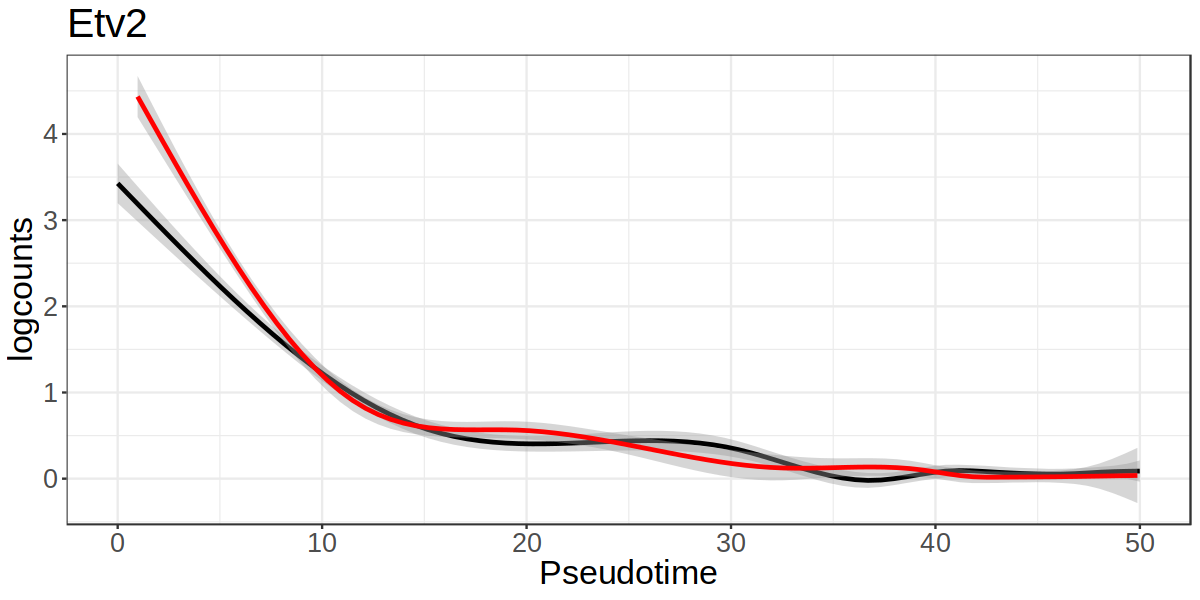

In [18]:
plot_traj('Etv2', size=0.01, alpha=0.1)

## Supplementary figure 1

In [6]:
# Load meta
meta = meta[,sample_name := str_replace_all(sample, opts$rename.samples)] %>% 
    .[,sample_name := factor(sample_name, levels=paste0('Sample_', 1:16))] %>% 
    .[pass_rnaQC==TRUE]

# colors for X-axis labels
x_col = meta %>% unique(by='sample_name') %>% 
    .[,x_col := str_replace_all(tdTom, c('TRUE' = 'red', 'FALSE' = 'black'))] %>%
    .[order(sample_name)] %>% 
    .$x_col

In [61]:
sce = load_SingleCellExperiment(io$rna.sce, cells=meta$cell, normalise = TRUE)

In [63]:
sce

class: SingleCellExperiment 
dim: 29453 38437 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(38437): SLX-21143_SITTA2_HTJH3DSX2#AAACCCAAGATGTTCC-1
  SLX-21143_SITTA2_HTJH3DSX2#AAACCCATCAGACCTA-1 ...
  SLX-21143_SITTH3_HTJH3DSX2#TTTGTTGAGGCGCTTC-1
  SLX-21143_SITTH3_HTJH3DSX2#TTTGTTGGTAAGATCA-1
colData names(12): sample barcode ... pass_rnaQC sizeFactor
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [66]:
p1 = ggplot(meta, aes(sample_name, log10(nCount_RNA), fill=stage)) + 
    geom_violin() +
    geom_boxplot(outlier.shape=NA, coef=1.5, fill='white', width=0.2) +
    scale_fill_manual(values=opts$stage.colors) +
    ylab('Log10(Num. Reads)') + 
    theme_classic() +
    theme(
        axis.text.y = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=20),
        axis.text.x = element_text(colour=x_col,size=15, angle=90, hjust=1, vjust=0.5),
        axis.title.x = element_blank(),
        legend.position = 'none'
    )

p2 = ggplot(meta, aes(sample_name, nFeature_RNA, fill=stage)) + 
    geom_violin() +
    geom_boxplot(outlier.shape=NA, coef=1.5, fill='white', width=0.2) +
    scale_fill_manual(values=opts$stage.colors) +
    ylab('Num. Genes') + 
    theme_classic() +
    theme(
        axis.text.y = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=20),
        axis.text.x = element_text(colour=x_col,size=15, angle=90, hjust=1, vjust=0.5),
        axis.title.x = element_blank(),
        legend.position = 'none'
    )

p3 = ggplot(meta, aes(sample_name, mitochondrial_percent_RNA, fill=stage)) + 
    geom_violin() +
    geom_boxplot(outlier.shape=NA, coef=1.5, fill='white', width=0.2) +
    scale_fill_manual(values=opts$stage.colors) +
    ylab('% Mitochondrial expression') + 
    theme_classic() +
    theme(
        axis.text.y = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=20),
        axis.text.x = element_text(colour=x_col,size=15, angle=90, hjust=1, vjust=0.5),
        axis.title.x = element_blank(),
        legend.position = 'none'
    )

tdtom_perc = meta %>% copy() %>%
    .[,Tomato := ifelse(as.vector(counts(sce['tomato-td'])) > 0, 1, 0)] %>% 
    .[,`:=`(tdTom_pos = sum(Tomato), total = .N), by=sample_name] %>% 
    unique(by='sample_name') %>%
    .[,perc_tomato := round(tdTom_pos/total*100, 1)]

p4 = ggplot(meta, aes(sample_name, as.vector(logcounts(sce['tomato-td'])))) + 
    geom_point(position = position_jitterdodge(jitter.width =0.8, jitter.height=0.03), size=0.05, alpha=0.2, aes(col=tdTom)) + 
    geom_text(data = tdtom_perc, aes(y=6, label = paste0(perc_tomato, '%')), size=5, angle=90, hjust=1) + 
    scale_color_manual(values=c('TRUE'='red', 'FALSE'='black')) + 
    theme_bw() + 
    ylab('Normalised tdTom expression') + 
   # ylim(0,4.3) + 
    theme(
        axis.text.y = element_text(colour="black",size=15),
        axis.title.y = element_text(colour="black",size=20),
        axis.text.x = element_text(colour=x_col,size=15, angle=90, hjust=1, vjust=0.5),
        axis.title.x = element_blank(),
        legend.position = 'none'
    )

options(repr.plot.width = 25, repr.plot.height=7)
p = ggarrange(p1, p2, p3, p4, nrow=1)

pdf(file.path(io$basedir, '/results/Suppl/QC_metrics.pdf'), width=20, height=5)
    print(p)
dev.off()

        # legend.text = element_text(size=15),
        # legend.title = element_text(size=20) 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


png 
  2

In [241]:
### Correlating marker gene expression between chimera and atlas

In [242]:
celltype_order <- c("ExE ectoderm",
            "Epiblast",
            "Caudal epiblast",
            "Primitive Streak",
            "Nascent mesoderm",
            "PGC",
            "Haematoendothelial progenitors", 
            "EMP", 
            "MEP", 
            "Megakaryocyte progenitors", 
            "Blood progenitors", 
            "Erythroid", 
            "Chorioallantoic-derived erythroid progenitors",
            "YS endothelium",
            "Venous endothelium",
            "Embryo proper endothelium",
            "Allantois endothelium",
            "YS mesothelium-derived endothelial progenitors",
            "YS mesothelium",
            "Embryo proper mesothelium",
            "Mesenchyme",
            "Allantois",
            "Cranial mesoderm",
            "Pharyngeal mesoderm",
            "Cardiopharyngeal progenitors",
            "Cardiopharyngeal progenitors SHF",
            "Anterior cardiopharyngeal progenitors",
            "Cardiopharyngeal progenitors FHF",
            "Cardiomyocytes FHF 1",
            "Cardiomyocytes FHF 2",
            "Cardiomyocytes SHF 1",
            "Cardiomyocytes SHF 2",
            "Epicardium",
            "Endocardium",
            "Lateral plate mesoderm",
            "Limb mesoderm",
            "Forelimb",
            "Intermediate mesoderm", "Kidney primordium",
            "Paraxial mesoderm", 
            "Presomitic mesoderm", 
            "Somitic mesoderm",
            "Anterior somitic tissues",
            "Posterior somitic tissues",
            "Dermomyotome", 
            "Endotome", 
            "Sclerotome","Caudal mesoderm", 
            "NMPs", 
            "NMPs/Mesoderm-biased",
            "Node",
            "Notochord",
            "Frontonasal mesenchyme",
            "Amniotic ectoderm",
            "Surface ectoderm",
            "Epidermis",
            "Placodal ectoderm",
            "Otic placode",
            "Otic neural progenitors",
            "Limb ectoderm",
            "Neural tube",
            "Optic vesicle",
            "Early dorsal forebrain progenitors",
            "Late dorsal forebrain progenitors",
            "Ventral forebrain progenitors",
            "Midbrain progenitors",
            "Dorsal midbrain neurons",
            "Midbrain/Hindbrain boundary",
            "Dorsal hindbrain progenitors", 
            "Hindbrain floor plate",
            "Hindbrain neural progenitors",
            "Ventral hindbrain progenitors",
            "Dorsal spinal cord progenitors",
            "Spinal cord progenitors",
            "Migratory neural crest",
            "Branchial arch neural crest",
            "Ectoderm", "Non-neural ectoderm",
            "Parietal endoderm", 
            "ExE endoderm",
            "Visceral endoderm",
            "Anterior Primitive Streak",
            "Gut tube",
            "Foregut",
            "Midgut",
            "Hindgut",
            "Pharyngeal endoderm",
            "Thyroid primordium")

In [127]:
# Load Atlas
atlas = load_SingleCellExperiment(io$rna.atlas.sce, normalise = TRUE)

In [268]:
library(BiocParallel)
BPPARAM = MulticoreParam(22)

# Get marker gene list
markers = fread('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/extended/atlas_marker_genes_seurat.csv') %>%
    .[p_val_adj<1e-3 & avg_log2FC>1.5]
marker_genes = markers[gene %in% rownames(atlas) & gene %in% rownames(sce), gene]

# subset both datasets to marker genes only
atlas_filt = atlas[unique(marker_genes),]
sce_filt = sce[unique(marker_genes),]

# pseudobulk both datasets by celltype
atlas.pb = aggregateAcrossCells(atlas_filt, id=atlas_filt$celltype_extended_atlas, statistics="mean", use.assay.type="logcounts", BPPARAM = BPPARAM)
sce.pb = aggregateAcrossCells(sce_filt, id=meta$celltype.mapped_mnn, statistics="mean", use.assay.type="logcounts", BPPARAM = BPPARAM)

# Perform pairwise correlation between for all celltypes between the 2 datasets 
celltypes = colnames(sce.pb)

correlations = mclapply(celltypes, function(x){
    # Get atlas counts for the celltype
    atlas_counts = as.vector(logcounts(atlas.pb[,x]))
    
    # Correlate with every celltype in chimera object
    calc_correlations = lapply(celltypes, function(y){
        chimera_counts = as.vector(logcounts(sce.pb[,y]))
        corr = cor(atlas_counts, chimera_counts, method='pearson')
    }) %>% data.table() %>% setnames('Correlation') %>% 
        .[,`:=`(atlas=x, chimera=celltypes)]
    return(calc_correlations)
}, mc.cores=22) %>% rbindlist() %>% 
    .[,Correlation:=as.numeric(Correlation)] %>% 
    .[,`:=`(atlas=factor(atlas, levels=celltype_order), chimera=factor(chimera, levels=celltype_order))]

In [269]:
options(repr.plot.width=15, repr.plot.height=13)
p = ggplot(correlations, aes(atlas, chimera, fill=Correlation)) + 
    geom_tile() + 

    # viridis::scale_fill_viridis(
    #             limits=c(1,100),
    #             breaks = c(0, 25, 50, 75, 100)) + 
    scale_fill_gradientn(colors=rev(rainbow(4)),
                         limits=c(0,1),
                breaks = c(0, 0.50, 1)) + 
    xlab('Atlas') + ylab('Chimera Mapped Celltype') + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          axis.text = element_text(color='black'),
          axis.title = element_text(size=20),
          legend.text = element_text(size=15),
          legend.title = element_text(size=20))

pdf(file.path(io$basedir, '/results/Suppl/mapping_correlation.pdf'), width=15, height=12)
    print(p)
dev.off()


png 
  2

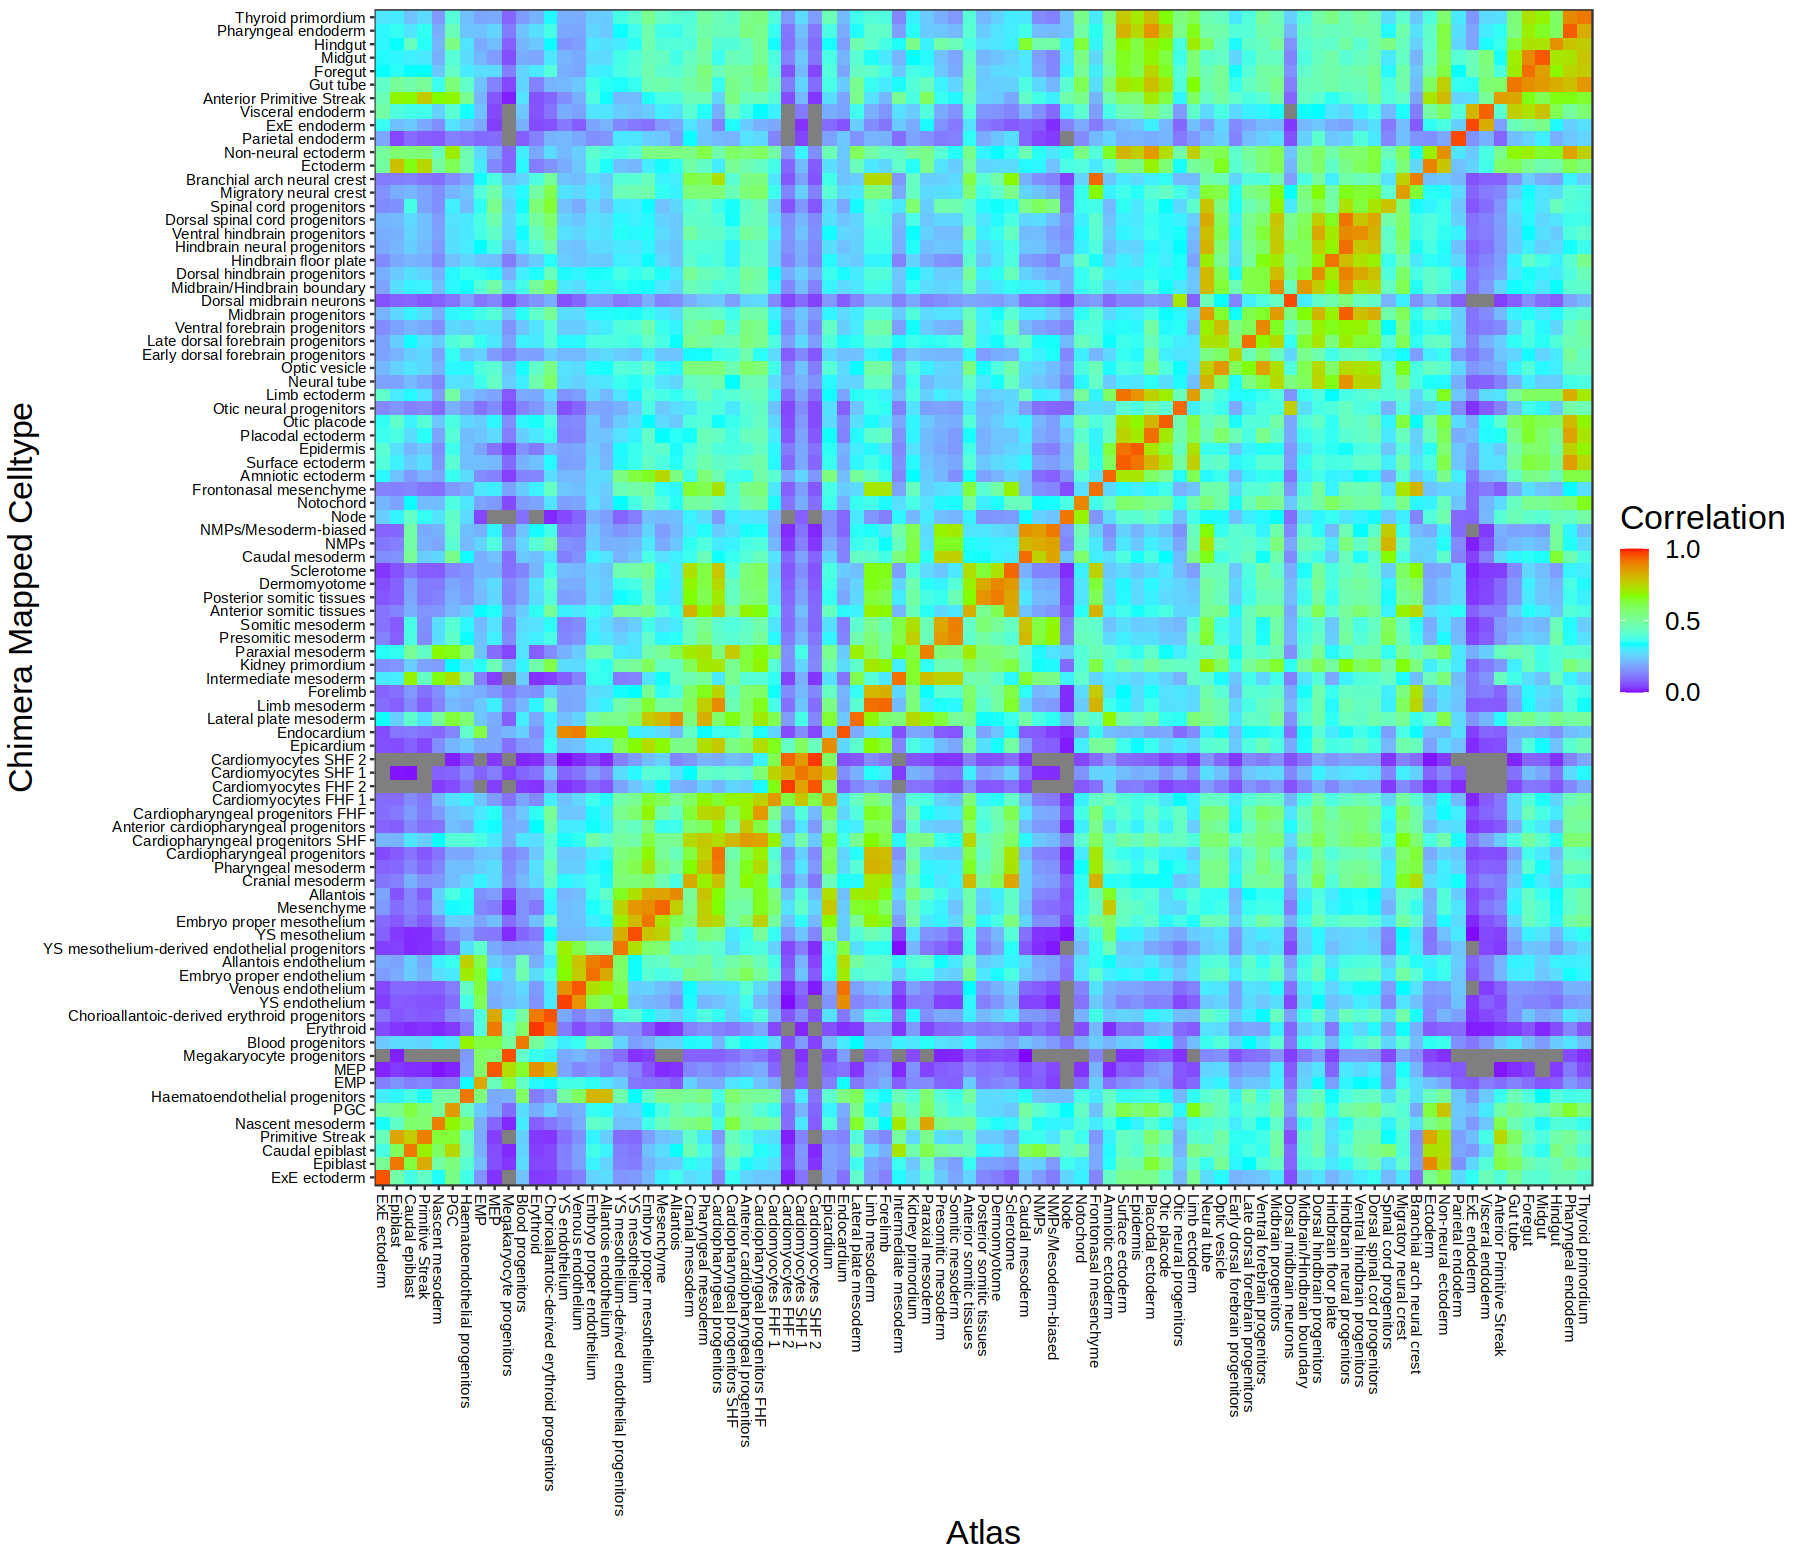

In [270]:
p

## Supplementary figure 2

In [6]:
DE_files = list.files(file.path(io$basedir, 'results/rna/differential/'))

In [7]:
DE_files_tmp = DE_files[grep('_tdTom_corrFalse_pseudobulk.txt.gz', DE_files)]

In [8]:
# Load in all DEG files
DEGs.dt = lapply(DE_files_tmp, function(x){fread(file.path(io$basedir, 'results/rna/differential/', x))}) %>%
    rbindlist() %>%
   .[stage %in% c('E7.5', 'E8.5', 'E9.5')] %>% 
   .[,celltype_stage:=paste0(celltype, stage)] 

In [9]:
DE_files_tmp

[1] "DEresults_stageE7.5_E8.5_E9.5_tdTom_corrFalse_pseudobulk.txt.gz"
[2] "DEresults_stageE7.5_tdTom_corrFalse_pseudobulk.txt.gz"          
[3] "DEresults_stageE8.5_tdTom_corrFalse_pseudobulk.txt.gz"          
[4] "DEresults_stageE9.5_tdTom_corrFalse_pseudobulk.txt.gz"

In [446]:
# DEGs.dt = rbind(fread(file.path(io$basedir, 'results/rna/differential/DEresults_stageE7.5_tdTom_corrFalse_singlecell.txt.gz')) %>% 
#                     .[,stage:='E7.5'],
#                 fread(file.path(io$basedir, 'results/rna/differential/DEresults_stageE8.5_tdTom_corrFalse_singlecell.txt.gz')) %>% 
#                     .[,stage:='E8.5'],
#                 fread(file.path(io$basedir, 'results/rna/differential/DEresults_stageE9.5_tdTom_corrFalse_singlecell.txt.gz')) %>% 
#                     .[,stage:='E9.5'])%>% 
#    .[,celltype_stage:=paste0(celltype, stage)] 

In [10]:
# keep only genes signicant in minimum of 2 cases
genes_keep = as.data.table(table(DEGs.dt$gene, DEGs.dt$sig), keep.rownames=T) %>% 
    .[V2==T & N>1]

In [11]:
# keep only celltypes with minimum X number of significant genes
celltypes_keep = as.data.table(table(DEGs.dt$celltype_stage, DEGs.dt$sig), keep.rownames=T) %>% 
    .[V2==T& N>10] %>% setnames('V1', 'celltype_stage')

DEGs.dt = DEGs.dt %>% 
    merge(., celltypes_keep, by='celltype_stage') %>% 
    .[,celltype_significant := paste0(celltype, ' (', N, ')')]

In [12]:
DEGs = DEGs.dt[gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]

In [13]:
features = unique(DEGs %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 10), by=celltype] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype_stage')] %>%
    dcast(., celltype_stage ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype_stage')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels=opts$celltypes)] %>% 
    .[order(celltype)] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=12, repr.plot.height=18)
p1 = ggplot(to.plot, aes(celltype_significant, gene, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') + 
    geom_rect(xmin = 4.5, xmax = 5.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Erythroid (155)')) + 
    geom_rect(xmin = 0.5, xmax = 1.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Blood progenitors (35)')) + 
    facet_grid(col=vars(stage), scale='free', space='free') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15),
         strip.background=element_rect(fill='white'),
         strip.text=element_text(size=20))

pdf(file.path(io$basedir, '/results/Suppl/DEGs_all.pdf'), width=12, height=18)
    print(p1)
dev.off()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


png 
  2

In [14]:
DEGs = DEGs.dt[gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]
features = unique(DEGs %>% .[order(-abs(logFC)), ] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype_stage')] %>%
    dcast(., celltype_stage ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype_stage')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

In [15]:
DEGs = DEGs.dt[stage == 'E7.5' & gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]

features = unique(DEGs %>% .[order(-abs(logFC)), ]) %>% .[,head(.SD, 20), by=celltype] %>% .$gene

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels=opts$celltypes)] %>% 
    .[order(celltype)] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=4, repr.plot.height=10)
p2 = ggplot(to.plot, aes(celltype_significant, gene, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') + 
    geom_rect(xmin = 4.5, xmax = 5.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Erythroid (155)')) + 
    geom_rect(xmin = 0.5, xmax = 1.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Blood progenitors (35)')) + 
    facet_grid(col=vars(stage), scale='free', space='free') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15),
         strip.background=element_rect(fill='white'),
         strip.text=element_text(size=20))

pdf(file.path(io$basedir, '/results/Suppl/DEGs_E75.pdf'), width=length(unique(to.plot$celltype))/6+3, height=length(unique(to.plot$gene))/4)
    print(p2)
dev.off()

png 
  2

In [16]:
DEGs = DEGs.dt[stage == 'E8.5' & gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]

features = unique(DEGs %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 15), by=celltype] %>% .$gene)

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels=opts$celltypes)] %>% 
    .[order(celltype)] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=6, repr.plot.height=17)
p3 = ggplot(to.plot, aes(celltype_significant, gene, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') + 
    geom_rect(xmin = 4.5, xmax = 5.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Erythroid (155)')) + 
    geom_rect(xmin = 0.5, xmax = 1.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Blood progenitors (35)')) + 
    facet_grid(col=vars(stage), scale='free', space='free') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15),
         strip.background=element_rect(fill='white'),
         strip.text=element_text(size=20))

pdf(file.path(io$basedir, '/results/Suppl/DEGs_E85.pdf'), width=length(unique(to.plot$celltype))/6+3, height=length(unique(to.plot$gene))/4)
    print(p3)
dev.off()

png 
  2

In [17]:
DEGs = DEGs.dt[stage == 'E9.5' & gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]

features = unique(DEGs %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 20), by=celltype] %>% .$gene)

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels=opts$celltypes)] %>% 
    .[order(celltype)] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=7, repr.plot.height=17)
p4 = ggplot(to.plot, aes(celltype_significant, gene, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') + 
    geom_rect(xmin = 4.5, xmax = 5.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Erythroid (155)')) + 
    geom_rect(xmin = 0.5, xmax = 1.5, ymin = -Inf, ymax = Inf,
        fill = NA, col='red', size=0.3,
        data = subset(to.plot, celltype_significant == 'Blood progenitors (35)')) + 
    facet_grid(col=vars(stage), scale='free', space='free') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15),
         strip.background=element_rect(fill='white'),
         strip.text=element_text(size=20))

pdf(file.path(io$basedir, '/results/Suppl/DEGs_E95.pdf'), width=length(unique(to.plot$celltype))/6+3, height=length(unique(to.plot$gene))/4)
    print(p4)
dev.off()

png 
  2

In [1]:
# DEGs = DEGs.dt[gene %in% genes_keep$V1 & celltype_stage %in% celltypes_keep$celltype_stage]

# features = unique(DEGs %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 10000), by=celltype] %>% .$gene)

# # Turn dt in matrix
# DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype_stage')] %>%
#     dcast(., celltype_stage ~ gene, value.var = 'logFC')
# DEGs.mtx[is.na(DEGs.mtx)] = 0
# DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype_stage')

# # Cluster genes by logFC
# order = hclust(dist(t(DEGs.mtx)))

# # prepare data.table for plotting
# to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
#     .[, gene := factor(gene, levels = order$labels[order$order])] %>%
#     .[, celltype := factor(celltype, levels=opts$celltypes)] %>% 
#     .[order(celltype)] %>%
#     .[, logFC_capped := ifelse(logFC >= 2, 2, 
#                                ifelse(logFC <= -2, -2, logFC))]

# options(repr.plot.width=12, repr.plot.height=15)
# p1 = ggplot(to.plot, aes(celltype_significant, gene, size=-log10(padj_fdr), col=logFC_capped)) + 
#     geom_point() + 
#     scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
#     xlab('') + ylab('') + 
#     geom_rect(xmin = 4.5, xmax = 5.5, ymin = -Inf, ymax = Inf,
#         fill = NA, col='red', size=0.3,
#         data = subset(to.plot, celltype_significant == 'Erythroid (155)')) + 
#     geom_rect(xmin = 0.5, xmax = 1.5, ymin = -Inf, ymax = Inf,
#         fill = NA, col='red', size=0.3,
#         data = subset(to.plot, celltype_significant == 'Blood progenitors (35)')) + 
#     facet_grid(col=vars(stage), scale='free', space='free') + 
#     theme_classic() + 
#     theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
#           axis.text.y=element_blank(),
#          axis.text=element_text(size=12, color='black'),
#          text=element_text(size=15),
#          strip.background=element_rect(fill='white'),
#          strip.text=element_text(size=20))

# p1

In [18]:
############
## Panel B
############

# Tweak the graph plotting to also incluse the cells in the background
plotNhoodGraph_with_cells = function(x, layout = "UMAP", colour_by = NA, subset.nhoods = NULL, 
    size_range = c(0.5, 3), node_stroke = 0.3, ...) 
{
    if (!miloR:::.valid_graph(nhoodGraph(x))) {
        stop("Not a valid Milo object - neighbourhood graph is missing. Please run buildNhoodGraph() first.")
    }
    if (is.character(layout)) {
        if (!layout %in% names(reducedDims(x))) {
            stop(layout, "isn't in readucedDim(x) - choose a different layout")
        }
    }
    nh_graph <- nhoodGraph(x)
    if (!is.null(subset.nhoods)) {
        nh_graph <- igraph::induced_subgraph(nh_graph, vids = which(as.numeric(V(nh_graph)$name) %in% 
            unlist(nhoodIndex(x)[subset.nhoods])))
    }
    nh_graph <- igraph::permute(nh_graph, order(igraph::vertex_attr(nh_graph)$size, 
        decreasing = TRUE))
    if (is.character(layout)) {
        redDim <- layout
        layout <- reducedDim(x, redDim)[as.numeric(igraph::vertex_attr(nh_graph)$name), 
            ]
        if (!any(class(layout) %in% c("matrix"))) {
            warning("Coercing layout to matrix format")
            layout <- as(layout, "matrix")
        }
    }
    if (!is.na(colour_by)) {
        if (colour_by %in% colnames(colData(x))) {
            col_vals <- colData(x)[as.numeric(igraph::vertex_attr(nh_graph)$name), 
                colour_by]
            if (!is.numeric(col_vals)) {
                col_vals <- as.character(col_vals)
            }
            igraph::V(nh_graph)$colour_by <- col_vals
        }
        else {
            stop(colour_by, "is not a column in colData(x)")
        }
        
   # umap.dt = reducedDim(x, redDim) %>% as.data.table()
        
    }
    else {
        igraph::V(nh_graph)$colour_by <- igraph::V(nh_graph)$size
        colour_by <- "Nhood size"
    }
    if (colour_by %in% c("logFC")) {
        plot.g <- simplify(nh_graph)
        pl <- ggraph::ggraph(simplify(nh_graph), layout = layout) + 
            ggrastr::geom_point_rast(data=umap.dt, aes(UMAP1, UMAP2), color='#fffed9', size=0.01, alpha=1, raster.dpi=150) + 
            ggraph::geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha = 0.2) + 
            ggraph::geom_node_point(aes(fill = colour_by, size = size), shape = 21, stroke = node_stroke) + 
            scale_size(range = size_range, name = "Nhood size") + 
            ggraph::scale_edge_width(range = c(0.2, 3), name = "overlap size") + 
            theme_classic(base_size = 14) + 
            theme(axis.line = element_blank(), 
                axis.text = element_blank(), axis.ticks = element_blank(), 
                axis.title = element_blank())
    }
    else {
        pl <- ggraph::ggraph(simplify(nh_graph), layout = layout) + ggraph::geom_edge_link0(aes(width = weight), 
            edge_colour = "grey66", edge_alpha = 0.2) + ggraph::geom_node_point(aes(fill = colour_by, 
            size = size), shape = 21, stroke = node_stroke) + 
            scale_size(range = size_range, name = "Nhood size") + 
            scale_edge_width(range = c(0.2, 3), name = "overlap size") + 
            theme_classic(base_size = 14) + theme(axis.line = element_blank(), 
            axis.text = element_blank(), axis.ticks = element_blank(), 
            axis.title = element_blank())
    }
    if (is.numeric(igraph::V(nh_graph)$colour_by)) {
        pl <- pl + scale_fill_gradient2(name = colour_by)
    }
    else {
        mycolors <- colorRampPalette(brewer.pal(11, "Spectral"))(length(unique(igraph::V(nh_graph)$colour_by)))
        pl <- pl + scale_fill_manual(values = mycolors, name = colour_by, 
            na.value = "white")
    }
    pl
}

# Get UMAP
umap.dt = fread(file.path(io$basedir, 'results/rna/dimensionality_reduction/sce/umap_features2500_pcs40_neigh30_dist0.3.txt.gz')) %>% 
    merge(meta, by='cell')

## E7.5
# Load MILO results
milo = readRDS(file.path(io$basedir, 'results/rna/MiloR/E7.5_Milo_features2500_pcs40_tdTomcorrTrue.rds'))
milo_results = fread(file.path(io$basedir, 'results/rna/MiloR/E7.5_Milo_features2500_pcs40_tdTomcorrTrue_DAresults.csv'))

# Put the UMAP into the milo object
umap.mtx = umap.dt[,c(1,2,3)] %>% 
    .[match(colnames(milo), cell),] %>% 
    .[!is.na(cell)]  %>% 
     as.data.frame() %>% tibble::column_to_rownames('cell') %>% 
     as.matrix

summary(rownames(umap.mtx) == colnames(milo))

reducedDims(milo)$umap = umap.mtx

signif_res <- milo_results
signif_res[signif_res$SpatialFDR > 0.05, 'logFC'] <- 0
colData(milo)['logFC'] <- NA
colData(milo)[unlist(nhoodIndex(milo)[signif_res$Nhood]), 'logFC'] <- signif_res[, 'logFC']

p1 = plotNhoodGraph_with_cells(milo, colour_by = 'logFC')

## E8.5
# Load MILO results
milo = readRDS(file.path(io$basedir, 'results/rna/MiloR/E8.5_Milo_features2500_pcs40_tdTomcorrTrue.rds'))
milo_results = fread(file.path(io$basedir, 'results/rna/MiloR/E8.5_Milo_features2500_pcs40_tdTomcorrTrue_DAresults.csv'))

# Put the UMAP into the milo object
umap.mtx = umap.dt[,c(1,2,3)] %>% 
    .[match(colnames(milo), cell),] %>% 
    .[!is.na(cell)]  %>% 
     as.data.frame() %>% tibble::column_to_rownames('cell') %>% 
     as.matrix

summary(rownames(umap.mtx) == colnames(milo))

reducedDims(milo)$umap = umap.mtx

signif_res <- milo_results
signif_res[signif_res$SpatialFDR > 0.05, 'logFC'] <- 0
colData(milo)['logFC'] <- NA
colData(milo)[unlist(nhoodIndex(milo)[signif_res$Nhood]), 'logFC'] <- signif_res[, 'logFC']

p2 = plotNhoodGraph_with_cells(milo, colour_by = 'logFC')

Loading required package: miloR

Loading required package: edgeR

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




   Mode    TRUE 
logical    5068 

   Mode    TRUE 
logical   11364 

In [19]:
pdf(file.path(io$basedir, '/results/Suppl/MILO_results_E75.pdf'), width=7, height=5)
    print(p1)
dev.off()

pdf(file.path(io$basedir, '/results/Suppl/MILO_results_E85.pdf'), width=7, height=5)
    print(p2)
dev.off()

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


png 
  2

png 
  2

# Exporting processed files

In [8]:
sce = readRDS(io$rna.sce)

In [66]:
library(Matrix)
counts = counts(sce)
writeMM(counts, file.path(io$basedir, '/processed/postQC_counts.mtx'))
writeLines(colnames(counts), file.path(io$basedir, '/processed/postQC_colnames.txt'))
writeLines(rownames(counts), file.path(io$basedir, '/processed/postQC_rownames.txt'))

NULL

### R version & packages used

In [3]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.2                         
year           2022                        
month          10                          
day            31                          
svn rev        83211                       
language       R                           
version.string R version 4.2.2 (2022-10-31)
nickname       Innocent and Trusting       

In [2]:
ip <- as.data.frame(installed.packages()[,c(1,3:4)])
rownames(ip) <- NULL
ip <- ip[is.na(ip$Priority),1:2,drop=FALSE]
print(ip, row.names=FALSE)

                      Package    Version
                        abind      1.4-5
                     annotate     1.76.0
                AnnotationDbi     1.60.0
                AnnotationHub      3.6.0
                        ArchR      1.0.2
                     argparse      2.2.1
                      askpass        1.1
                   assertthat      0.2.1
                    backports      1.4.1
                    base64enc      0.1-3
                     basilisk     1.9.12
               basilisk.utils     1.10.0
                    batchelor     1.14.0
                     beachmat     2.14.0
                     beeswarm      0.4.0
                           BH   1.78.0-0
                      Biobase     2.58.0
                BiocFileCache      2.6.0
                 BiocGenerics     0.44.0
                       BiocIO      1.8.0
                  BiocManager    1.30.19
                BiocNeighbors     1.16.0
                 BiocParallel     1.32.5
                